# Credit Card Fraud Detection using Autoencoder and DNN

This notebook uses an autoencoder and DNN to detect anomalies in credit card transactions, identifying potential fraudulent activity.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Load dataset
data = pd.read_csv(r"C:\Users\shahi\OneDrive\Desktop\creditcard.csv")

# Standardize 'Amount' and 'Time'
scaler = StandardScaler()
data['Amount'] = scaler.fit_transform(data[['Amount']])
data['Time'] = scaler.fit_transform(data[['Time']])

# Drop 'Class' column for X and keep it in y
X = data.drop('Class', axis=1)
y = data['Class']


In [3]:
# Use only normal (non-fraudulent) data for training
normal_data = data[data.Class == 0].drop('Class', axis=1)
fraud_data = data[data.Class == 1].drop('Class', axis=1)

X_train, X_val = train_test_split(normal_data, test_size=0.2, random_state=42)


In [4]:
# Define Autoencoder architecture
input_dim = X_train.shape[1]

input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(8, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(encoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 16)                496       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 16)                144       
                                                                 
 dense_3 (Dense)             (None, 30)                510       
                                                                 
Total params: 1,286
Trainable params: 1,286
Non-trainable params: 0
_________________________________________________________________


In [5]:
# Train the model
history = autoencoder.fit(X_train, X_train,
                          epochs=20,
                          batch_size=32,
                          validation_data=(X_val, X_val),
                          shuffle=True)


Epoch 1/20
7108/7108 [==============================] - 21s 3ms/step - loss: 0.4459 - val_loss: 0.3437
Epoch 2/20
7108/7108 [==============================] - 16s 2ms/step - loss: 0.3124 - val_loss: 0.2934
Epoch 3/20
7108/7108 [==============================] - 17s 2ms/step - loss: 0.2855 - val_loss: 0.2860
Epoch 4/20
7108/7108 [==============================] - 15s 2ms/step - loss: 0.2775 - val_loss: 0.2793
Epoch 5/20
7108/7108 [==============================] - 16s 2ms/step - loss: 0.2744 - val_loss: 0.2706
Epoch 6/20
7108/7108 [==============================] - 16s 2ms/step - loss: 0.2720 - val_loss: 0.2690
Epoch 7/20
7108/7108 [==============================] - 18s 2ms/step - loss: 0.2697 - val_loss: 0.2677
Epoch 8/20
7108/7108 [==============================] - 21s 3ms/step - loss: 0.2676 - val_loss: 0.2643
Epoch 9/20
7108/7108 [==============================] - 19s 3ms/step - loss: 0.2664 - val_loss: 0.2631
Epoch 10/20
7108/7108 [==============================] - 17s 2ms/step - l

In [6]:
# Calculate reconstruction error on training set
reconstructions = autoencoder.predict(X_train)
mse = np.mean(np.power(X_train - reconstructions, 2), axis=1)

# Set threshold (95th percentile of training errors)
threshold = np.percentile(mse, 95)
print("Reconstruction error threshold:", threshold)


7108/7108 [==============================] - 8s 1ms/step
Reconstruction error threshold: 0.6206515395207257


In [7]:
# Predict on entire dataset
X_full = data.drop('Class', axis=1)
y_full = data['Class']

reconstructions_full = autoencoder.predict(X_full)
mse_full = np.mean(np.power(X_full - reconstructions_full, 2), axis=1)

# Classify as fraud if error > threshold
y_pred = [1 if e > threshold else 0 for e in mse_full]

print(classification_report(y_full, y_pred))
print("ROC AUC Score:", roc_auc_score(y_full, mse_full))


8901/8901 [==============================] - 10s 1ms/step
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    284315
           1       0.03      0.89      0.06       492

    accuracy                           0.95    284807
   macro avg       0.51      0.92      0.52    284807
weighted avg       1.00      0.95      0.97    284807

ROC AUC Score: 0.9682269279650748


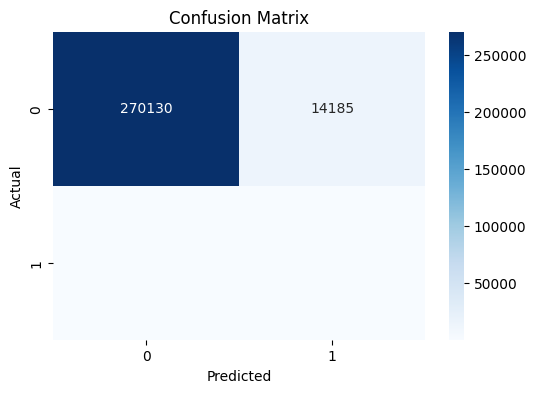

In [8]:
# Confusion matrix
cm = confusion_matrix(y_full, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


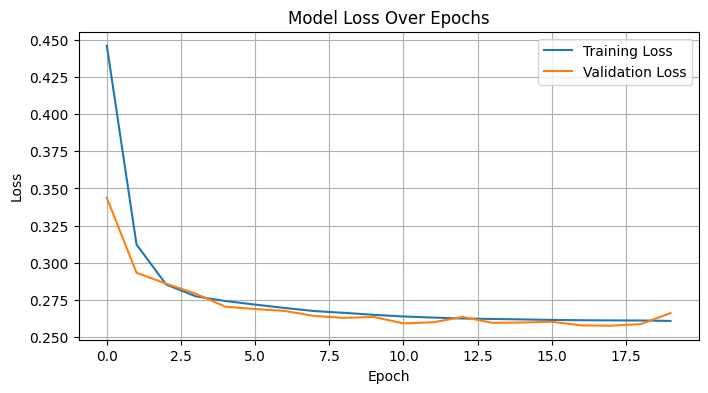

In [9]:
# Plot training & validation loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
import time

# Simulate real-time fraud detection on 10 transactions
print("Simulating real-time fraud detection...")

for i in range(10):  # Simulate first 10 transactions
    sample = X_full.iloc[i].values.reshape(1, -1)
    true_class = y_full.iloc[i]

    reconstruction = autoencoder.predict(sample)
    mse = np.mean(np.power(sample - reconstruction, 2))
    predicted_class = 1 if mse > threshold else 0

    print(f"Transaction {i+1}: True Class = {true_class}, Predicted = {predicted_class}, MSE = {mse:.6f}")
    time.sleep(1)  # Pause for 1 second to simulate real-time delay


Simulating real-time fraud detection...
1/1 [==============================] - 0s 336ms/step
Transaction 1: True Class = 0, Predicted = 0, MSE = 0.162055
1/1 [==============================] - 0s 20ms/step
Transaction 2: True Class = 0, Predicted = 0, MSE = 0.052875
1/1 [==============================] - 0s 21ms/step
Transaction 3: True Class = 0, Predicted = 1, MSE = 0.852960
1/1 [==============================] - 0s 20ms/step
Transaction 4: True Class = 0, Predicted = 0, MSE = 0.407514
1/1 [==============================] - 0s 18ms/step
Transaction 5: True Class = 0, Predicted = 0, MSE = 0.198411
1/1 [==============================] - 0s 21ms/step
Transaction 6: True Class = 0, Predicted = 0, MSE = 0.050014
1/1 [==============================] - 0s 21ms/step
Transaction 7: True Class = 0, Predicted = 0, MSE = 0.219092
1/1 [==============================] - 0s 34ms/step
Transaction 8: True Class = 0, Predicted = 0, MSE = 0.275106
1/1 [==============================] - 0s 38ms/step
Tra

# DNN #

In [11]:
# Split the data
X_train_dnn, X_test_dnn, y_train_dnn, y_test_dnn = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler_dnn = StandardScaler()
X_train_dnn = scaler_dnn.fit_transform(X_train_dnn)
X_test_dnn = scaler_dnn.transform(X_test_dnn)


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the DNN model
dnn_model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_dnn.shape[1],)),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')  # Output for binary classification
])

dnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
dnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                992       
                                                                 
 dense_5 (Dense)             (None, 16)                528       
                                                                 
 dense_6 (Dense)             (None, 8)                 136       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,665
Trainable params: 1,665
Non-trainable params: 0
_________________________________________________________________


In [13]:
history_dnn = dnn_model.fit(X_train_dnn, y_train_dnn, 
                            epochs=20, 
                            batch_size=32, 
                            validation_split=0.2,
                            verbose=1)


Epoch 1/20
5697/5697 [==============================] - 11s 2ms/step - loss: 0.0121 - accuracy: 0.9966 - val_loss: 0.0031 - val_accuracy: 0.9993
Epoch 2/20
5697/5697 [==============================] - 10s 2ms/step - loss: 0.0032 - accuracy: 0.9994 - val_loss: 0.0027 - val_accuracy: 0.9994
Epoch 3/20
5697/5697 [==============================] - 9s 2ms/step - loss: 0.0028 - accuracy: 0.9995 - val_loss: 0.0026 - val_accuracy: 0.9993
Epoch 4/20
5697/5697 [==============================] - 10s 2ms/step - loss: 0.0027 - accuracy: 0.9994 - val_loss: 0.0026 - val_accuracy: 0.9994
Epoch 5/20
5697/5697 [==============================] - 10s 2ms/step - loss: 0.0025 - accuracy: 0.9995 - val_loss: 0.0026 - val_accuracy: 0.9995
Epoch 6/20
5697/5697 [==============================] - 9s 2ms/step - loss: 0.0024 - accuracy: 0.9995 - val_loss: 0.0028 - val_accuracy: 0.9994
Epoch 7/20
5697/5697 [==============================] - 11s 2ms/step - loss: 0.0021 - accuracy: 0.9995 - val_loss: 0.0031 - val_accu

1781/1781 [==============================] - 2s 1ms/step - loss: 0.0037 - accuracy: 0.9995
Test Accuracy: 0.9995
1781/1781 [==============================] - 2s 883us/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.89      0.78      0.83        98

    accuracy                           1.00     56962
   macro avg       0.95      0.89      0.92     56962
weighted avg       1.00      1.00      1.00     56962



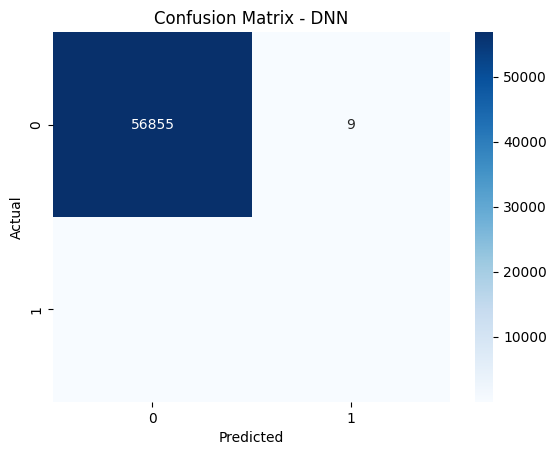

In [14]:
# Evaluate on test set
loss, accuracy = dnn_model.evaluate(X_test_dnn, y_test_dnn)
print(f"Test Accuracy: {accuracy:.4f}")

# Predict
y_pred_dnn = (dnn_model.predict(X_test_dnn) > 0.5).astype("int32")

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test_dnn, y_pred_dnn))
confusion = confusion_matrix(y_test_dnn, y_pred_dnn)

sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - DNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


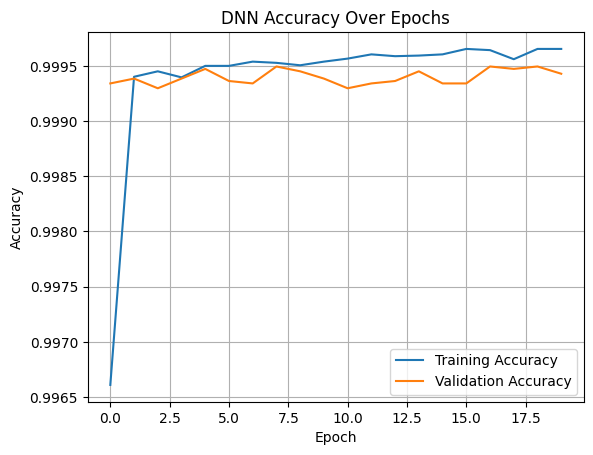

In [15]:
plt.plot(history_dnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_dnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('DNN Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Autoencoder metrics
ae_accuracy = accuracy_score(y_full, y_pred)
ae_precision = precision_score(y_full, y_pred)
ae_recall = recall_score(y_full, y_pred)
ae_f1 = f1_score(y_full, y_pred)
ae_auc = roc_auc_score(y_full, mse_full)

# DNN metrics
dnn_accuracy = accuracy_score(y_test_dnn, y_pred_dnn)
dnn_precision = precision_score(y_test_dnn, y_pred_dnn)
dnn_recall = recall_score(y_test_dnn, y_pred_dnn)
dnn_f1 = f1_score(y_test_dnn, y_pred_dnn)
dnn_auc = roc_auc_score(y_test_dnn, y_pred_dnn)

# Print comparison
print("🔍 Model Performance Comparison:")
print("-" * 50)
print(f"{'Metric':<20}{'Autoencoder':<15}{'DNN Classifier'}")
print(f"{'Accuracy':<20}{ae_accuracy:.4f}{'':<5}{dnn_accuracy:.4f}")
print(f"{'Precision':<20}{ae_precision:.4f}{'':<5}{dnn_precision:.4f}")
print(f"{'Recall':<20}{ae_recall:.4f}{'':<5}{dnn_recall:.4f}")
print(f"{'F1 Score':<20}{ae_f1:.4f}{'':<5}{dnn_f1:.4f}")
print(f"{'ROC AUC':<20}{ae_auc:.4f}{'':<5}{dnn_auc:.4f}")


🔍 Model Performance Comparison:
--------------------------------------------------
Metric              Autoencoder    DNN Classifier
Accuracy            0.9500     0.9995
Precision           0.0300     0.8941
Recall              0.8902     0.7755
F1 Score            0.0580     0.8306
ROC AUC             0.9682     0.8877
